In [1]:
import os
import numpy as np
from sklearn.mixture import GMM
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# Read the ELG metadata as an example.  Focus on D4000 vs EW([OII]).
ff = fits.getdata(os.path.join(os.getenv('DESI_BASIS_TEMPLATES'),'elg_templates_v1.5.fits'),1)
X = np.array((ff['D4000'],np.log10(ff['OII_3727_EW']))).T

In [3]:
# Model the distribution using a mixture of Gaussians (try n=3).  Draw 1000 points.
model = GMM(n_components=3, covariance_type="full").fit(X)
samp = model.sample(1000)

/Users/david/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


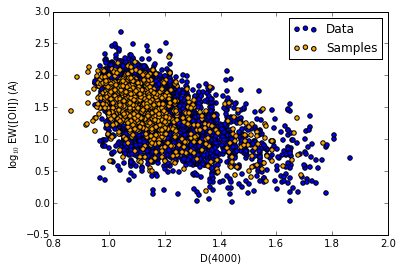

In [4]:
# Make a plot.  Looks pretty good!
plt.scatter(X[:,0],X[:,1],label='Data')
plt.scatter(samp[:,0],samp[:,1],c='orange',label='Samples')
plt.xlabel('D(4000)')
plt.ylabel('log$_{10}$ EW([OII]) (A)')
plt.xlim((0.8,2.0))
plt.legend()
plt.show()

In [5]:
# But how many components should we use? Get the Bayesian information criterion and find the minimum.
ncomp = np.arange(2,11)
bic = np.ndarray(len(ncomp))
for ii, nc in enumerate(ncomp):
    bic[ii] = GMM(n_components=nc, covariance_type="full").fit(X).bic(X)
    print(nc, bic[ii])

(2, -13848.843205285397)
(3, -14089.257240353945)
(4, -14086.414012952906)
(5, -14039.191467868313)
(6, -13993.640386706849)
(7, -13894.209258259267)
(8, -13891.62140856159)
(9, -13819.850986852216)
(10, -13780.005181873661)


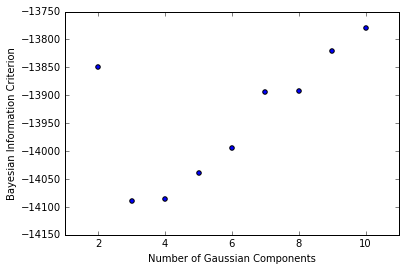

In [6]:
# Make a plot.  Looks like 3 is about right!
plt.scatter(ncomp,bic)
plt.xlabel('Number of Gaussian Components')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [7]:
# But now the question: what's the best way to store the model?!?  Pickle file?  ASCII?

## Save GMM Components

In [8]:
import astropy.io.fits as fits

In [9]:
def save_gmm_to_fits(model, filename):
    hdus = fits.HDUList()
    hdr = fits.Header()
    hdr['covtype'] = model.covariance_type
    hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
    hdus.append(fits.ImageHDU(model.means_, name='means'))
    hdus.append(fits.ImageHDU(model.covars_, name='covars'))
    hdus.writeto(filename, clobber=True)

## Restore and Sample GMM Model

In [10]:
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
    
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X

In [11]:
model2 = GaussianMixtureModel.load('model.fits')

In [12]:
samp2 = model2.sample(1000)

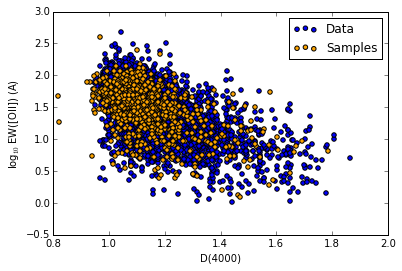

In [13]:
plt.scatter(X[:,0],X[:,1],label='Data')
plt.scatter(samp2[:,0],samp2[:,1],c='orange',label='Samples')
plt.xlabel('D(4000)')
plt.ylabel('log$_{10}$ EW([OII]) (A)')
plt.xlim((0.8,2.0))
plt.legend()
plt.show()